In [48]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 2
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

y_train = (y_train == 5).astype(np.int)
y_test = (y_test == 5).astype(np.int)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/12
469/469 [==============================] - 5s 10ms/step - loss: 0.5249 - accuracy: 0.8838 - val_loss: 0.3912 - val_accuracy: 0.9108
Epoch 2/12
469/469 [==============================] - 5s 10ms/step - loss: 0.3470 - accuracy: 0.9097 - val_loss: 0.3086 - val_accuracy: 0.9108
Epoch 3/12
469/469 [==============================] - 5s 10ms/step - loss: 0.3088 - accuracy: 0.9097 - val_loss: 0.2932 - val_accuracy: 0.9108
Epoch 4/12
469/469 [==============================] - 5s 10ms/step - loss: 0.2972 - accuracy: 0.9097 - val_loss: 0.2828 - val_accuracy: 0.9108
Epoch 5/12
469/469 [==============================] - 5s 11ms/step - loss: 0.2868 - accuracy: 0.9097 - val_loss: 0.2721 - val_accuracy: 0.9108
Epoch 6/12
469/469 [==============================] - 5s 10ms/step - loss: 0.2776 - accuracy: 0.9097 - val_loss: 0.2614 - val_accuracy: 0.9108
Epoch 7/12
469/469 [==============================] - 5s 10ms/step - 

In [50]:
y_test.shape

(10000, 2)

In [51]:
y_pred = model.predict(x_test)
y_pred.shape

(10000, 2)

In [52]:
y_test_flat = np.argmax(y_test, axis=1)
y_pred_flat = np.array([np.argmax(x) for x in y_pred])

print(y_pred_flat.shape, y_test_flat.shape)

(10000,) (10000,)


In [55]:
from sklearn.metrics import accuracy_score
# Accuracy
acc = accuracy_score(y_test_flat, y_pred_flat) * 100
print("Accuracy :", acc)

Accuracy : 91.14


In [56]:
# Classification report

confusion_mtx = confusion_matrix(y_test_flat, y_pred_flat) 
print(confusion_mtx)
target_names = ['0', '1']
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names))

[[9108    0]
 [ 886    6]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9108
           1       1.00      0.01      0.01       892

    accuracy                           0.91     10000
   macro avg       0.96      0.50      0.48     10000
weighted avg       0.92      0.91      0.87     10000



In [65]:
tn, fp, fn, tp = confusion_matrix(y_test_flat, y_pred_flat).ravel()
print(tn, fp, fn, tp )
sensitivity = tp /(tp + fn)
print(sensitivity * 100)

9108 0 886 6
0.672645739910314


In [66]:
fp+fn

886

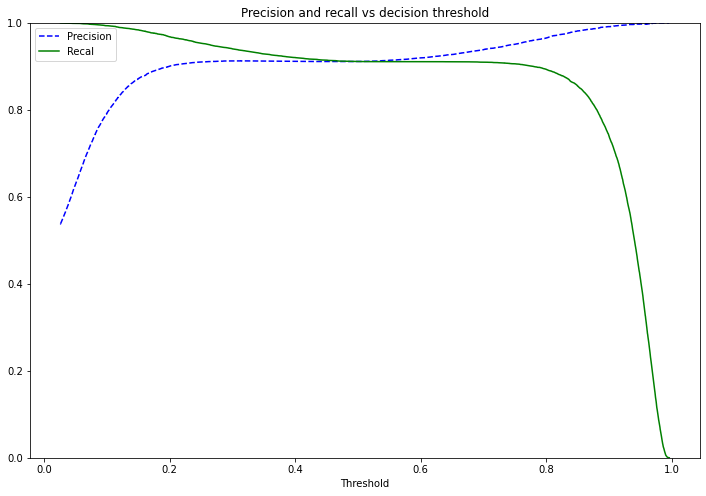

In [70]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_test.ravel(), y_pred.ravel())

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.figure(figsize=(12,8))
    plt.title('Precision and recall vs decision threshold')
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recal")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()


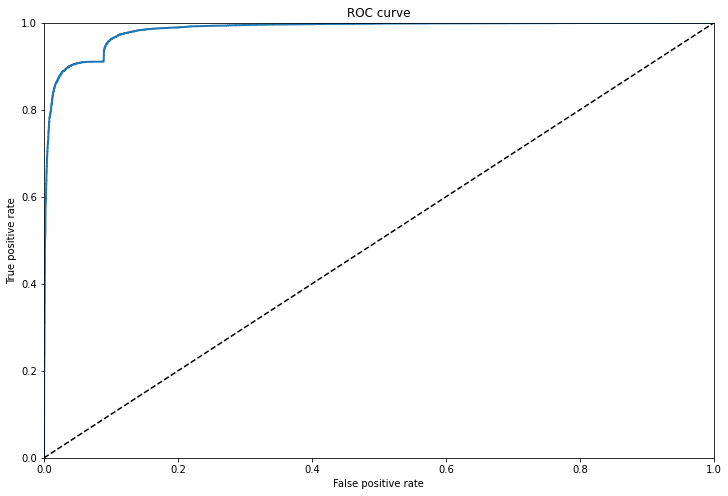

In [73]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test.ravel(),y_pred.ravel())

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,8))
    plt.title('ROC curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],"k--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

plot_roc_curve(fpr,tpr)
plt.show()


In [85]:
from sklearn.metrics import roc_auc_score
print('Area under ROC curve : ', roc_auc_score(y_test.ravel(), y_pred.ravel()) *100 )

Area under ROC curve :  98.435798


In [79]:
from sklearn.metrics import f1_score
F1_score = f1_score(y_test_flat, y_pred_flat, labels=None, average='binary', sample_weight=None)
F1_score * 100

1.33630289532294

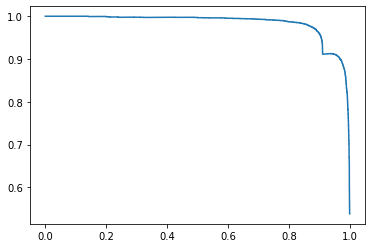

In [75]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# PR curve
precision, recall, thresholds = precision_recall_curve(y_test.ravel(), y_pred.ravel())
plt.figure(20)
plt.plot(recall,precision)

Area under the ROC curve for positive class: 0.9526937339863835


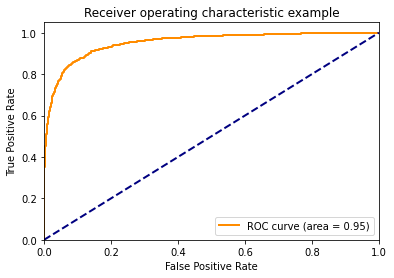

In [80]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
cls = 1 # class name
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#print(roc_auc)
print("Area under the ROC curve for positive class:", roc_auc[1])


plt.figure()
lw = 2 # line width
plt.plot(fpr[cls], tpr[cls], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()